In [17]:
import cosmax
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import powerbox

In [18]:
Ns = [32, 48, 64, 96, 128, 192, 256]

datas = []

for N in Ns:
    key = jax.random.PRNGKey(N)

    data = jax.random.normal(key, (N, N, N))

    datas.append(data)

# get gpus available to jax
print(jax.devices())

[CudaDevice(id=0)]


In [23]:
import time


time_cosmax = []
time_cosmax_cpu = []
time_powerbox = []

for N, data in zip(Ns, datas):
    cosmax_time_list = []
    cosmax_time_list_cpu = []
    powerbox_time_list = []

    power_spectrum = cosmax.spectral_ops.PowerSpectrum(N, N // 2, 1.0)
    jitted_power_spectrum = jax.jit(power_spectrum)
    jitted_power_spectrum_cpu = jax.jit(power_spectrum, backend='cpu')
    # warm up execution
    jitted_power_spectrum(data)
    jitted_power_spectrum_cpu(data)


    for i in range(5):

        start = time.time()
        jitted_power_spectrum(data)
        end = time.time()
        cosmax_time_list.append(end - start)

        start = time.time()
        jitted_power_spectrum_cpu(data)
        end = time.time()
        cosmax_time_list_cpu.append(end - start)

        start = time.time()
        powerbox.get_power(data, 1.0)
        end = time.time()

        powerbox_time_list.append(end - start)

    time_cosmax.append(cosmax_time_list)
    time_powerbox.append(powerbox_time_list)
    time_cosmax_cpu.append(cosmax_time_list_cpu)

time_cosmax = jnp.array(time_cosmax)
time_powerbox = jnp.array(time_powerbox)
time_cosmax_cpu = jnp.array(time_cosmax_cpu)

time_cosmax = jnp.mean(time_cosmax, axis=1)
time_powerbox = jnp.mean(time_powerbox, axis=1)
time_cosmax_cpu = jnp.mean(time_cosmax_cpu, axis=1)

/home/andrin/miniconda3/envs/cosmax/lib/python3.13/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)
/home/andrin/miniconda3/envs/cosmax/lib/python3.13/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)
/home/andrin/miniconda3/envs/cosmax/lib/python3.13/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_box

In [24]:
print(time_cosmax)
print(time_powerbox)
print(time_cosmax_cpu)

[0.00023522 0.00029368 0.00039868 0.00035629 0.00033774 0.00035114
 0.00032449]
[0.00268378 0.0077723  0.03790598 0.11346664 0.23297425 0.91802007
 2.160449  ]
[0.00113454 0.00202432 0.00267053 0.0037003  0.00844002 0.0254993
 0.06108975]


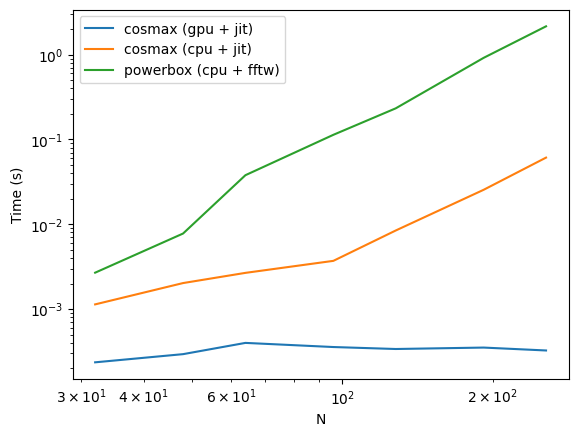

In [25]:
plt.plot(Ns, time_cosmax, label="cosmax (gpu + jit)")
plt.plot(Ns, time_cosmax_cpu, label="cosmax (cpu + jit)")
plt.plot(Ns, time_powerbox, label="powerbox (cpu + fftw)")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("N")
plt.ylabel("Time (s)")
plt.legend()
plt.show()
